# General Imports and Downloads

In [1093]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import nltk
from nltk.corpus import twitter_samples

In [1094]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/rishushrivastava/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [1095]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rishushrivastava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1096]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re

# Load the data

In [1097]:
def load_tweet():
    '''
        Load the positive and negative tweets
    '''
    positive_tweets = twitter_samples.strings('positive_tweets.json')
    negative_tweets = twitter_samples.strings('negative_tweets.json')
    
    return positive_tweets, negative_tweets

In [1098]:
positive_tweets, negative_tweets = load_tweet()

print(f'Positive Tweets length: {len(positive_tweets)}')
print(f'Negative Tweets length: {len(negative_tweets)}')

Positive Tweets length: 5000
Negative Tweets length: 5000


In [1099]:
## splitting the positive and negative tweets in 80:20 split

def split_pos_neg_tweets(pos_tweets, neg_tweets, split=0.8):
    '''
        Splits the positive and negative tweets and returns training and val_test datasets
    '''
    
    max_train_rows = int(len(pos_tweets) * split)
    
    print(f'Splitting the dataset in the ratio: {split}')
    
    train_pos = pos_tweets[:max_train_rows]
    val_pos = pos_tweets[max_train_rows:]
    
    train_neg = neg_tweets[:max_train_rows]
    val_neg = neg_tweets[max_train_rows:]
    
    train_label = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
    val_label = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))
    
    print(f'Total Training Rows (pos+neg) : {len(train_pos + train_neg)}')
    print(f'Total Validation Rows (pos+neg): {len(val_pos + val_neg)}')
    
    return train_pos + train_neg , val_pos + val_neg, train_label, val_label

In [1100]:
train_data, val_data, train_label, val_label = split_pos_neg_tweets(positive_tweets, negative_tweets)

Splitting the dataset in the ratio: 0.8
Total Training Rows (pos+neg) : 8000
Total Validation Rows (pos+neg): 2000


In [1101]:
print(f'Sample training data   : {train_data[6000]}')
print(f'Sample training label  : {train_label[6000]}')

Sample training data   : @stormieraae what the heck :( you don't follow her?
Sample training label  : 0.0


In [1102]:
print(f'Sample training data  : {train_data[0]}')
print(f'Sample training label : {train_label[0]}')

Sample training data  : #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Sample training label : 1.0


# Tweet Transformation

In [1103]:
stemmer = PorterStemmer()

def tweet_transform(tweets):
    '''
        Tokenize, remove stopword, remove hashtags and usernames, stem the words from tweets
    '''
    
    stop_words = stopwords.words('english')
    
    tweet = re.sub(r'#','',tweets)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','',tweet) ## remove any hyperlinks
    tweet = re.sub(r'^RT[\s]+','',tweet) ## remove any Retweets (RT)
    
    tokenizer = TweetTokenizer(preserve_case=True, reduce_len=False)
    tweet_tokenise = tokenizer.tokenize(tweet)
    
    cleaned_tweets = []
    
    for t in tweet_tokenise:
        if t not in stop_words and t[0] != '@': ## ignore stopwords and usernames
            stemmed_word = stemmer.stem(t) ## stem the words
            cleaned_tweets.append(stemmed_word)
    
    return cleaned_tweets
    

In [1104]:
print(f'Original Tweet: \n {train_data[0]} \n')
print(f'Transformed Tweet: \n {tweet_transform(train_data[0])}')

Original Tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :) 

Transformed Tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


In [1105]:
print(f'Original Tweet: \n {train_data[6000]} \n')
print(f'Transformed Tweet: \n {tweet_transform(train_data[6000])}')

Original Tweet: 
 @stormieraae what the heck :( you don't follow her? 

Transformed Tweet: 
 ['heck', ':(', 'follow', '?']


# Creating word vocabulary

In [1106]:
def tweet_vocab(tweets):
    '''
        The vocabulary of the tweet.
    '''
    
    vocab = {'__PAD__':0, '__</e>__':1, '__UNK__':2}
    
    for tweet in tweets:
        
        processed_tweet = tweet_transform(tweet)
        
        for word in processed_tweet:
            if word not in vocab:
                vocab[word] = len(vocab)
    
    return vocab

In [1107]:
vocab = tweet_vocab(train_data)

print(f'Total vocabulary : {len(vocab)}')

Total vocabulary : 9422


In [1108]:
train_df = pd.DataFrame({"data":train_data,"label":train_label})
val_df = pd.DataFrame({"data":val_data, "label":val_label})

In [1109]:
train_df['transformed_data'] = train_df['data'].apply(lambda x: tweet_transform(x))
val_df['transformed_data'] = val_df['data'].apply(lambda x: tweet_transform(x))

In [1110]:
train_df['transformed_data'].head()

0    [followfriday, top, engag, member, commun, wee...
1    [hey, jame, !, how, odd, :/, pleas, call, cont...
2    [listen, last, night, :), As, you, bleed, amaz...
3                                        [congrat, :)]
4    [yeaaaah, yippppi, !, !, !, accnt, verifi, rqs...
Name: transformed_data, dtype: object

# Convert to Tensor + Generator

In [1111]:
def tweet_to_tensor(tweet, vocab, unknown_token = '__UNK__', verbose=False):
    '''
        Converts a tweet to tensors
    '''
    
    tensor = []
    processed_tweet = tweet_transform(tweet)
    UNK_id = vocab.get(unknown_token)
    
    if verbose:
        print(f'List of Processed Tweets')
        print(processed_tweet)
    
    for word in processed_tweet:
        tensor.append(vocab.get(word,UNK_id))
        
    return tensor

In [1112]:
print(f'Actual Tweet : \n {val_data[0]}')
print(f'Tensor: {tweet_to_tensor(val_data[0],vocab,verbose=False)}')

Actual Tweet : 
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan
Tensor: [1146, 204, 402, 527, 2478, 808, 8447, 72, 1208, 808, 62, 2, 2803, 1905, 204, 856, 2, 2, 72, 386, 654, 2, 3656, 1096, 650, 4761, 9, 1146, 204, 177, 2, 2]


In [1113]:
train_df['transformed_data_tensor'] = train_df['data'].apply(lambda x: tweet_to_tensor(x,vocab))
val_df['transformed_data_tensor'] = val_df['data'].apply(lambda x: tweet_to_tensor(x,vocab))

In [1114]:
train_df['transformed_data_tensor'][0]

[3, 4, 5, 6, 7, 8, 9]

In [1115]:
train_df['label'][0]

1.0

In [1116]:
val_df['transformed_data_tensor'][3]

[657, 3662, 19, 489, 33, 9150, 489, 72, 2, 202, 108, 657, 9]

In [1117]:
class TweetDataset(Dataset):
    '''
        Dataset to process tweet
    '''
    
    def __init__(self, data, train=True):
        
        self.data = data
        self.train = train
        
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        X = self.data['transformed_data_tensor'][idx]
        
        if self.train:
            y = self.data['label'][idx]
        
        X = torch.tensor(X)
        
        if self.train:
            return X,y
        else:
            return X

In [1118]:
train_dataset = TweetDataset(train_df, train=True)
val_dataset = TweetDataset(val_df, train=True)

In [1119]:
def collate_fn_tweet(batch):
    '''
        Lookup the batch length and pads it with zeros. Essential for DataLoader in order to be of same size.
        Applicable for Train and Validation Tweets.
        
        Input:
            Batch: sequence of data from the dataloader
        Output:
            transformed_data: list of tensors of equal lengths of padded zero's.
    '''
    
    max_batch_length = max([ len(b[0]) for b in batch ])
    
    data = torch.LongTensor([list(data.numpy()) + [0] * (max_batch_length - data.shape[0]) for data, label in batch])
    label = torch.LongTensor([label for data, label in batch]).view(len(data),-1)
    #label = torch.Tensor([label for data, label in batch])
        
    return data, label

In [1120]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn_tweet)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn_tweet)

In [1121]:
for b, tl in enumerate(train_loader):
    break

<ipython-input-1119-cef3f1009f05>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label for data, label in batch]).view(len(data),-1)


In [1122]:
X_train, y_train = tl
print('Data :',X_train, '\nLabel:', y_train)

Data : tensor([[ 284,    9,   13,   72, 2265,   36,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 768,  152, 2719, 2720, 2721,   57,  197, 2722,  150,  152,  126,  365,
         2723, 2724, 2725, 2724,  275,  222,    9,   15],
        [3976, 2430,  260,   33,   77,  152,   57,  433, 3977,   53,   33,  635,
         3978,    9,    0,    0,    0,    0,    0,    0],
        [1496,  287,   86, 2891, 7052, 1807,   89, 3942,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 111, 2663,   24,   72,  561,   16,  111, 2663, 5486, 3942,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [1605,   88,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [1086,   12,   24,   33,  316,  751,   88,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 152, 2615,

In [1123]:
for b, p in enumerate(train_loader):
    break

<ipython-input-1119-cef3f1009f05>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label for data, label in batch]).view(len(data),-1)


In [1124]:
p[1].shape

torch.Size([10, 1])

In [1125]:
for b, val_tl in enumerate(val_loader):
    break

<ipython-input-1119-cef3f1009f05>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label for data, label in batch]).view(len(data),-1)


In [1126]:
X_val, y_val = val_tl

print('Data :',X_val,'\nLabel:',y_val)

Data : tensor([[ 153, 1557, 3942,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [  56,  733, 1026,    2,  507,  395,   12,  536,  490, 2008,  365,   51,
         6404,  203,  682,    2,    9],
        [2098, 1726,  126,   53,    2,   12, 3942,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [6147, 1094,   61,  466, 8259,  795,    9,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [ 459, 3942,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [   2,  133,   72,  152,  268,  152,   86, 5979,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [ 114,  111,  490, 3246,    9,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [2778,   33,  152,  655,  152,  153, 1553,  729,  381, 1516,    2,  606,
          179,    9,    0,    0,    0],
        [   2,    2, 2647

# Define Model

In [1127]:
class TweetDNNModel(nn.Module):
    
    def __init__(self, input_dim=len(vocab), embedding_dim=256, output_dim=1):
        super().__init__()
        
        self.embeddings = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, output_dim)
    
    def forward(self,x):
        
        x = self.embeddings(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.log_softmax(self.fc3(x),dim=1)
        
        return x

In [1128]:
model = TweetDNNModel()

model

TweetDNNModel(
  (embeddings): Embedding(9422, 256)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=1, bias=True)
)

In [1129]:
criterions = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model

In [1130]:
epochs = 10

train_losses = []
test_losses = []

train_corrects = []
test_corrects = []

for i in range(epochs):
    
    train_corr = 0
    test_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b+=1 
        
        y_predict = model(X_train)
        loss = criterions(y_predict, y_train)
        
        actual_predicted = np.where(torch.argmax(y_predict,1)>0,1,0)
        train_corr += (actual_predicted == y_train.reshape(-1,1).numpy()).sum()
        #print(train_corr)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%100 == 0:
            print(f'Epoch:{i} \t Batch:{b} [{10*b}/8000] \t Loss:{loss.item():10.8f} \t Accuracy:{10*(train_corr/b):10.3f}')
            
            
    train_losses.append(loss)
    train_corrects.append(train_corr)
    
    ## on the validation dataset
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            
            val_y_predict = model(X_val)
            val_predicted = np.where(torch.argmax(val_y_predict,1)>0,1,0)
            test_corr += (val_predicted == y_val.reshape(-1,1).numpy()).sum()
        
        val_loss = criterions(val_y_predict, y_val)
        test_losses.append(val_loss)
        test_corrects.append(test_corr)

<ipython-input-1119-cef3f1009f05>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label for data, label in batch]).view(len(data),-1)


Epoch:0 	 Batch:100 [1000/8000] 	 Loss:2.05860686 	 Accuracy:    55.700
Epoch:0 	 Batch:200 [2000/8000] 	 Loss:1.85340536 	 Accuracy:    55.000
Epoch:0 	 Batch:300 [3000/8000] 	 Loss:1.60914075 	 Accuracy:    55.667
Epoch:0 	 Batch:400 [4000/8000] 	 Loss:1.46006393 	 Accuracy:    55.650
Epoch:0 	 Batch:500 [5000/8000] 	 Loss:1.97912884 	 Accuracy:    55.700
Epoch:0 	 Batch:600 [6000/8000] 	 Loss:1.65710759 	 Accuracy:    55.483
Epoch:0 	 Batch:700 [7000/8000] 	 Loss:1.72724569 	 Accuracy:    55.357
Epoch:0 	 Batch:800 [8000/8000] 	 Loss:1.28889906 	 Accuracy:    55.450
Epoch:1 	 Batch:100 [1000/8000] 	 Loss:1.49639058 	 Accuracy:    59.400
Epoch:1 	 Batch:200 [2000/8000] 	 Loss:1.64025879 	 Accuracy:    57.850
Epoch:1 	 Batch:300 [3000/8000] 	 Loss:1.82040000 	 Accuracy:    58.467
Epoch:1 	 Batch:400 [4000/8000] 	 Loss:1.36415684 	 Accuracy:    58.600
Epoch:1 	 Batch:500 [5000/8000] 	 Loss:1.24720883 	 Accuracy:    58.520
Epoch:1 	 Batch:600 [6000/8000] 	 Loss:1.78772354 	 Accuracy:   

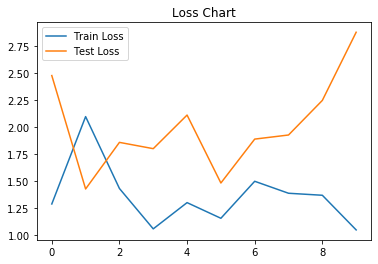

In [1131]:
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.legend()
plt.title('Loss Chart')
plt.show()

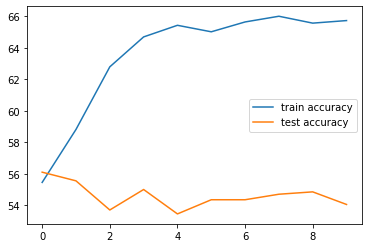

In [1132]:
plt.plot([(c/8000)*100 for c in train_corrects],label="train accuracy")
plt.plot([(c/2000)*100 for c in test_corrects],label="test accuracy")
plt.legend()
plt.show()

In [1133]:
## saving the model

torch.save(model.state_dict(),'tweet_sentiment_model.pt')